### Import necessary libraries. 

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import imblearn 
from imblearn.over_sampling import SMOTE # Oversampling
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed 
from sklearn.metrics import recall_score,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

## Functions

In [145]:
# Method for outlier detection via Inter-quartile range method: 
def outlier_detection_IQR(x, scale):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - scale * IQR 
    upper = Q3 + scale * IQR  
    outliers = ((x<lower)| (x>upper)).sum()
    total_length = len(x.index)
    percent_outlier = (outliers * 100 / total_length).round(3)
    print(x.name, "\tTotal outliers is: ", outliers,"\t", "\t Percentage Outliers: ", percent_outlier )    

In [159]:
# Method for outlier detection via Isolation forest method: 
def outlier_detection_IF(df_input):
    model = IsolationForest(n_estimators = 50, max_samples='auto', contamination=float(0.1), max_features=1.0)
    model.fit(df_input)
    df_input['anomaly']=model.predict(df_input)
    anomaly=df_input.loc[df_input['anomaly']==-1]
    anomaly_index=list(anomaly.index)
    print("\f The total number of anomalities in data is ", len(anomaly))
    return df_input  #anomaly

In [82]:
# Outlier treatment via Capping upper and lower 
def outlier_treatment_Capping(attr,threshold,dataframe):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        dataframe[attr.name] = np.where((dataframe[attr.name]>upper), upper , dataframe[attr.name])
        dataframe[attr.name] = np.where((dataframe[attr.name]<lower), lower , dataframe[attr.name])
    return dataframe

In [83]:
# Outlier treatment for Isoaltion forest detected outliers by deleting anomaly rows
def outlier_treatment_IF(dataframe):
    dataframe.drop(dataframe[dataframe.anomaly == -1].index, inplace=True)
    return dataframe

In [166]:
# Outlier treatment Replacing Outliers with Median Values
def outlier_treatment_IQR(attr,threshold,dataframe):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        dataframe[attr.name] = np.where((dataframe[attr.name]>upper)|(dataframe[attr.name]<lower), Q2 , dataframe[attr.name])
    return dataframe    

In [201]:
# Creating training set and test set for input dataframe
def preprocessing_TTS(dataframe):
    x = dataframe.iloc[:, 0: len(dataframe.columns)-1]
    y = dataframe.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [211]:
# Random forest feature selection based on the weights and gives best subset of features 
def RF_FeatureSelector(x_train, x_test, y_train, y_test):
    data_results = []

    for weight in range(1,20):
        forest = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40, class_weight={0:1,1:weight}, random_state = 42)
        forest.fit(x_train, y_train)
        model = SelectFromModel(forest, prefit=True)
        recall_ = recall_score(y_test, forest.predict(x_test), average='macro')
        names = model.get_support()
        data_results.append([weight, model.transform(x_train).shape[1], recall_.round(decimals=2), x_train.columns[names].values])
    return data_results

<b>Read data file</b>

In [84]:
#sets the maximum number of columns and rows displayed when a frame is pretty-printed
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [113]:
df = pd.read_csv('bankruptcy.csv')

In [116]:
#Replace the categorical column (class) values into binary
df_binary_class = df.copy(deep = True)
# Replace by class 0 and 1 values
df_binary_class['class']=pd.Categorical(df_binary_class['class'].replace({"b'0'" : 0, "b'1'":1}))
# Change the class variable from categorical to integer
df_binary_class['class']= pd.Categorical(df_binary_class['class']).codes
df_binary_class.describe()

Attr1         Attr2         Attr3         Attr4         Attr5  \
count  10503.000000  10503.000000  10503.000000  10485.000000  1.047800e+04   
mean       0.052844      0.619911      0.095490      9.980499 -1.347662e+03   
std        0.647797      6.427041      6.420056    523.691951  1.185806e+05   
min      -17.692000      0.000000   -479.730000      0.002080 -1.190300e+07   
25%        0.000686      0.253955      0.017461      1.040100 -5.207075e+01   
50%        0.043034      0.464140      0.198560      1.605600  1.579300e+00   
75%        0.123805      0.689330      0.419545      2.959500  5.608400e+01   
max       52.652000    480.730000     17.708000  53433.000000  6.854400e+05   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10503.000000  10503.000000  10489.000000  10500.000000  10503.000000   
mean      -0.121159      0.065624     19.140113      1.819254      0.366093   
std        6.970625      0.651152    717.756745      7.581659      6.428603   
min     -508.120000    -17.692000     -2.081800     -1.215700   -479.730000   
25%        0.000000      0.002118      0.431270      1.011275      0.297340   
50%        0.000000      0.050945      1.111000      1.199000      0.515500   
75%        0.072584      0.142275      2.857100      2.059100      0.725635   
max       45.533000     52.652000  53432.000000    740.440000     11.837000   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10503.000000  10485.000000  10460.000000  10503.000000  1.049500e+04   
mean       0.086764      2.411266      0.376563      0.065634  3.004332e+03   
std        0.655407    111.459642     49.675550      0.651151  1.091981e+05   
min      -17.692000  -1543.800000   -631.710000    -17.692000 -2.321800e+06   
25%        0.009809      0.006183      0.020740      0.002131  1.865950e+02   
50%        0.068104      0.155880      0.066433      0.050953  8.056900e+02   
75%        0.161090      0.570340      0.133612      0.142275  2.187100e+03   
max       52.652000   8259.400000   4972.000000     52.652000  1.023600e+07   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10489.000000  10489.000000  10503.000000  10460.000000  10460.000000   
mean       2.729654     20.511539      0.070739     -0.170778     68.448531   
std      110.233475    721.812766      0.835328     11.210201   1083.699904   
min     -204.300000     -0.043411    -17.692000   -771.650000     -0.001439   
25%        0.060302      1.449200      0.002131      0.001648     14.253750   
50%        0.235140      2.152500      0.050953      0.032117     34.432500   
75%        0.643030      3.924300      0.142285      0.087583     63.698250   
max     8259.400000  53433.000000     53.689000    123.940000  91600.000000   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count   9696.000000  10503.000000  10460.000000  10276.000000  10503.000000   
mean       4.670725      0.075676     -0.176466      0.211936      0.196153   
std      305.897238      0.581734     11.149274      2.093845      6.742161   
min       -1.107500    -17.692000   -771.650000    -60.742000   -500.750000   
25%        0.796673      0.000000      0.000556      0.014938      0.135695   
50%        0.955035      0.054633      0.027129      0.158370      0.377690   
75%        1.105650      0.145890      0.075935      0.373673      0.614100   
max    29907.000000     47.597000    123.940000    179.920000      8.834500   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10489.000000  9.788000e+03  10275.000000  10503.000000  10460.000000   
mean       2.580730  1.185945e+03      6.092884      3.921179      0.459346   
std      108.823993  3.469123e+04     94.713753      0.840528     71.755042   
min     -204.300000 -1.901300e+05   -690.400000     -0.358530  -6351.700000   
25%        0.055067  0.000000e+00      0.027178      3.3932

In [117]:
# Find top 20 columns with most null values
print(df_binary_class.isnull().sum().sort_values(ascending=False).head(20))      

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
Attr41     202
Attr32     101
Attr47      86
Attr52      86
Attr30      43
Attr20      43
Attr49      43
Attr23      43
Attr56      43
Attr39      43
dtype: int64


<BarContainer object of 65 artists>

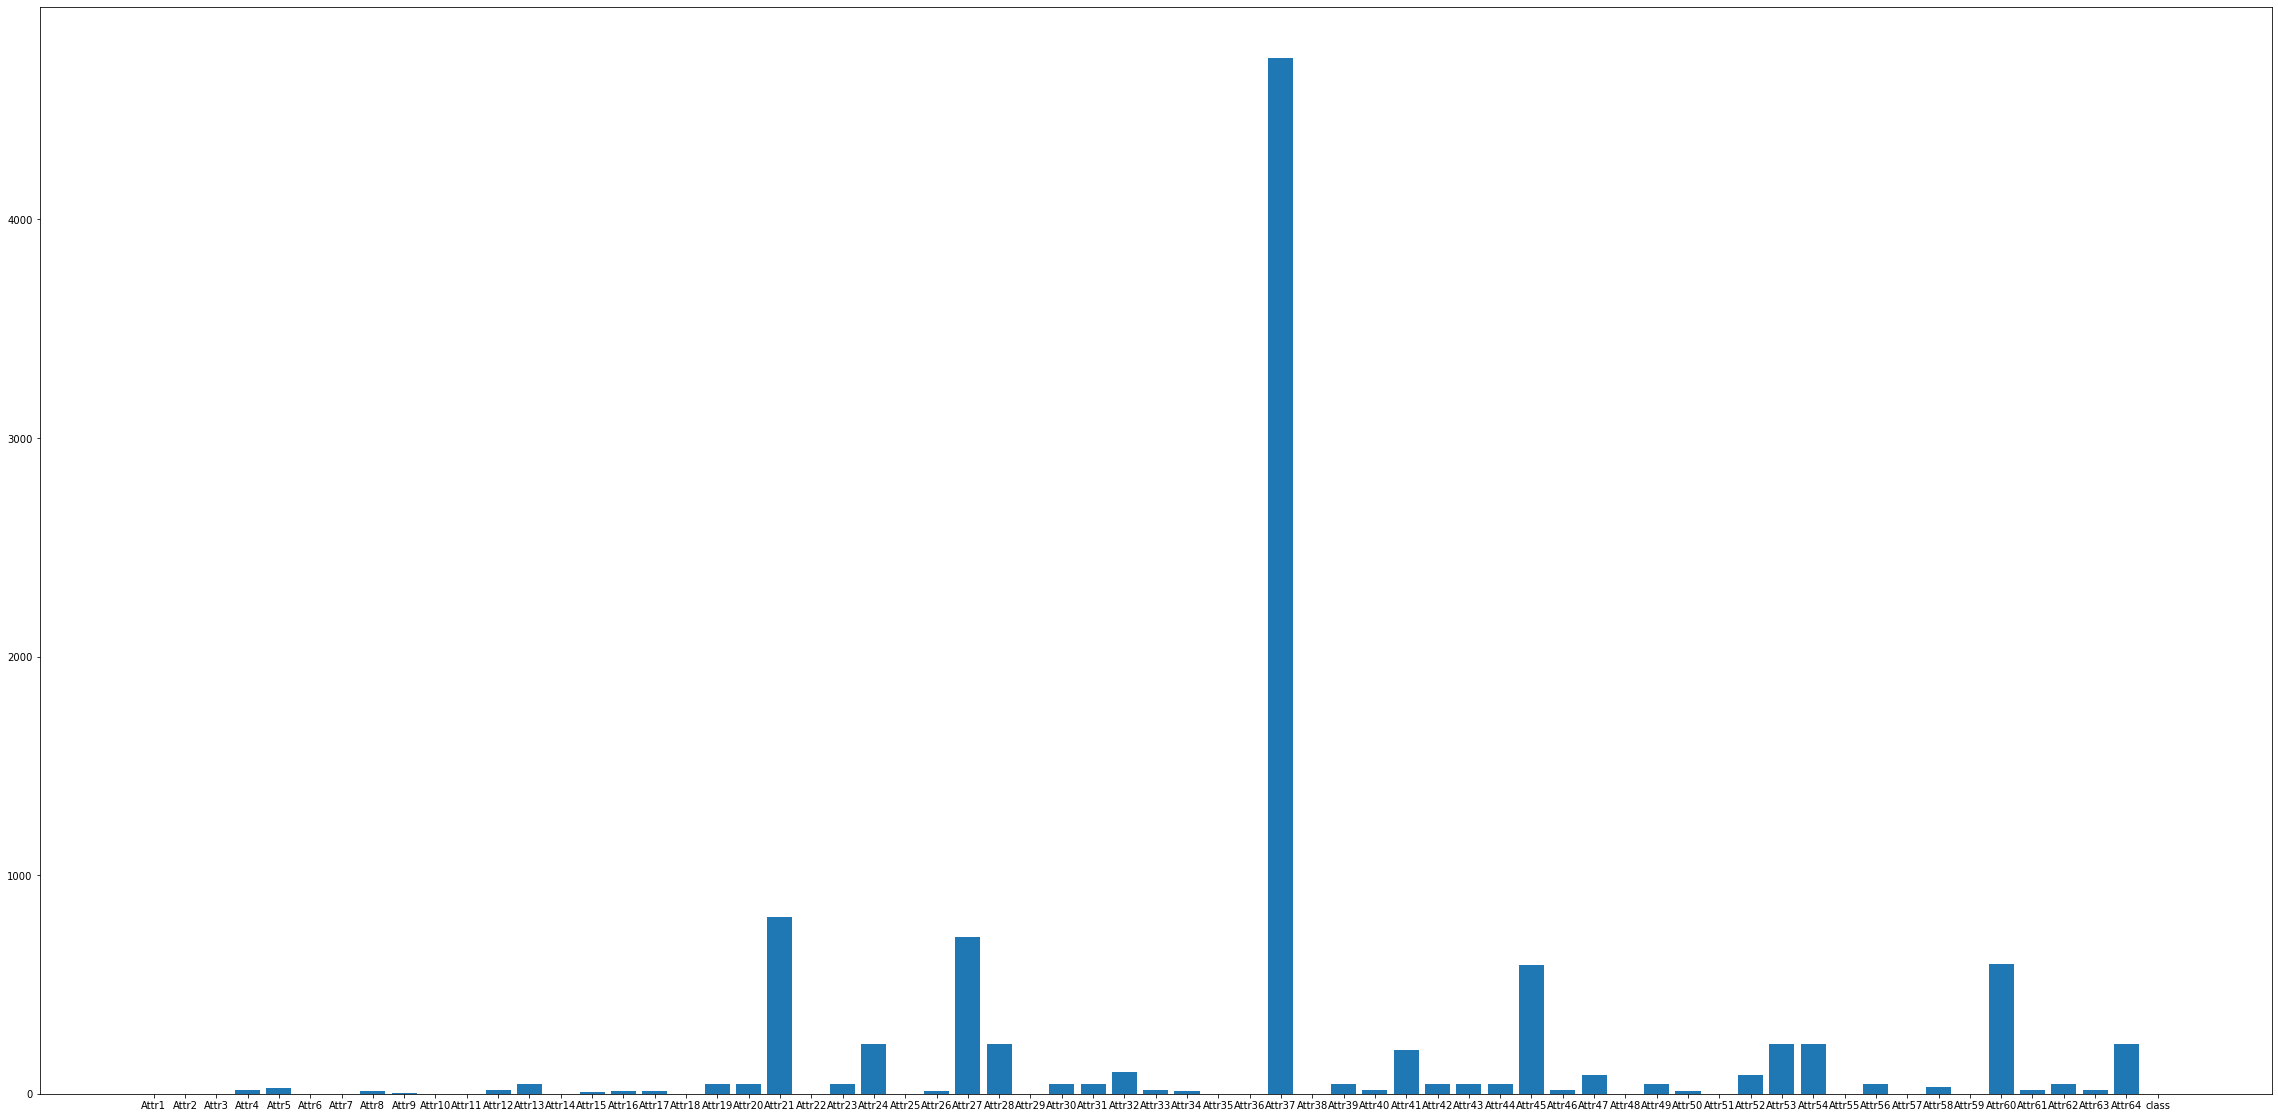

In [118]:
#replace the null values with 'nan'
df_binary_class = df_binary_class.replace('', np.nan)
nan_columns = []
nan_values = []
#count the number of  nan values in Dataset and plot a bargraph
for column in df_binary_class.columns:
    nan_columns.append(column)
    nan_values.append(df_binary_class[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

Column Attr37 contains the highest number of "Nan" values and data imputation on the column will nto be useful. Remove the column and plot the bar graph again

<BarContainer object of 64 artists>

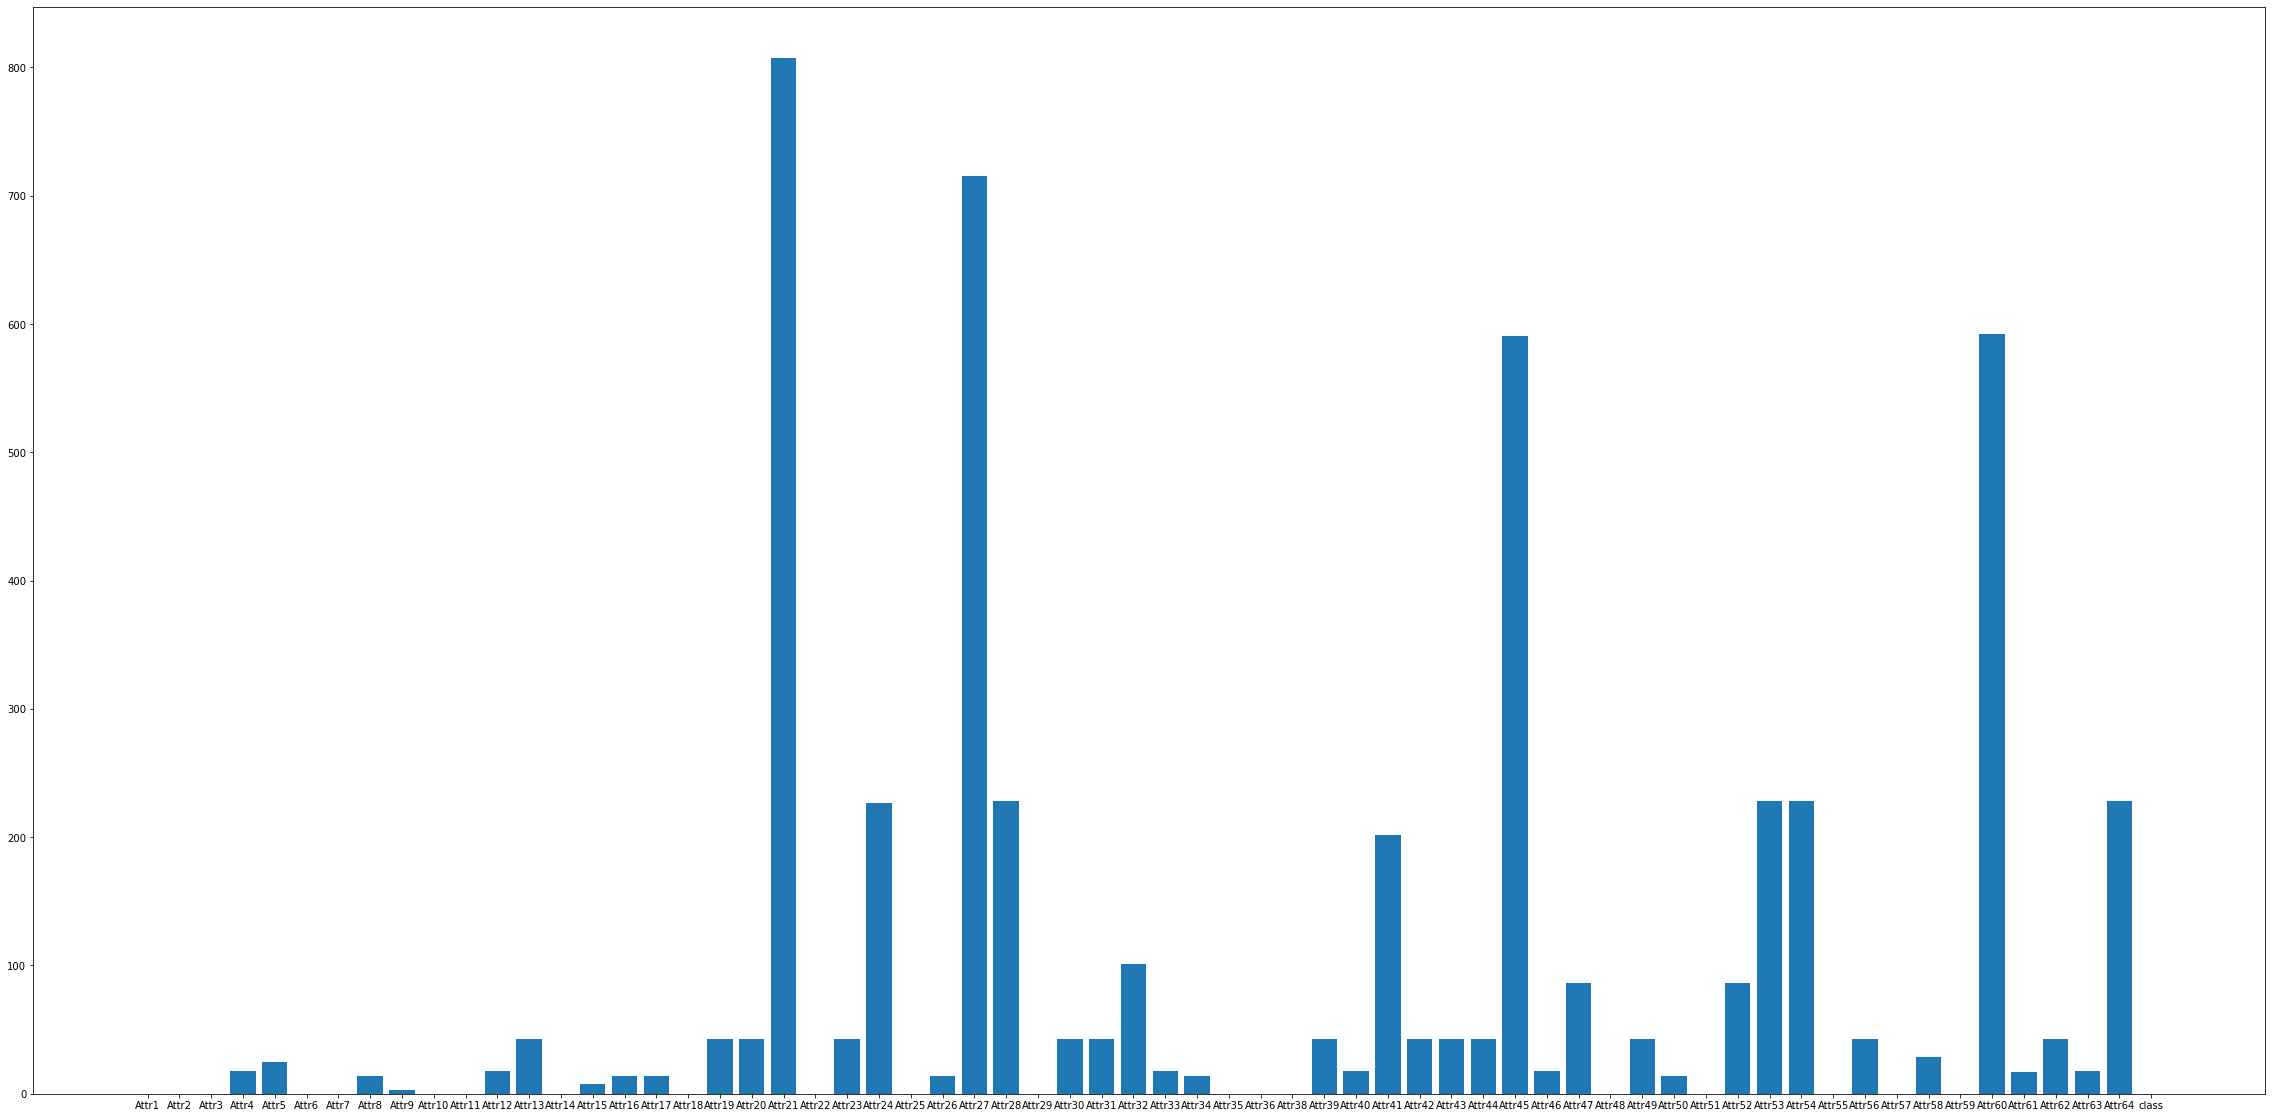

In [119]:
# Delete the column with highest number of nan values ie Column Attr37
df_binary_class = df_binary_class.drop(columns = ['Attr37'])
# Plot the null values graph after removing the Attr37 column
nan_columns = []
nan_values  = []

for column in df_binary_class.columns:
    nan_columns.append(column)
    nan_values.append(df_binary_class[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

<AxesSubplot:xlabel='class', ylabel='count'>

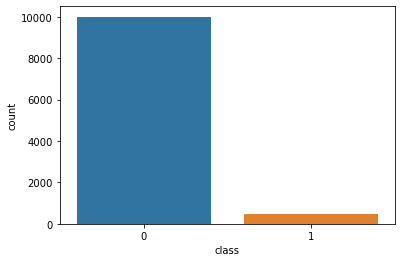

In [120]:
sns.countplot(x='class', data=df_binary_class)

Summary: Our data is highly imbalanced. The event rate of a company being bankrupt will be around 4.71% based on the data set provided.
In order to get a better accuracy rate instead of imputing the data as a whole we impute based on the 'class' attribute values. Create two different data frames according to the 'class' values and then concatenate the imputed data frames.

In [137]:
df_class_0 = df_binary_class[df_binary_class['class']==0]
df_class_1 = df_binary_class[df_binary_class['class']==1]

## Data Imputation

In [138]:
# Method to perform imputation on data frame. Pass data frame and the strategy via which imputation is to be carried out. 
def Imputation(data, approach):
    imputer = SimpleImputer(strategy = approach, missing_values = np.nan)
    imputer = imputer.fit(data)
    data_return = pd.DataFrame(imputer.transform(data.loc[:,:]), 
                             columns = data.columns)
  #  print("\f Imputed data via strategy: ", approach )
    return data_return

In [139]:
#Data imputation via median on original data seperated by class = 0
df_median_imputed_0 = df_class_0.copy()
df_median_imputed_0 = Imputation(df_median_imputed_0, 'median')

In [140]:
#Data imputation via median on original data seperated by class = 1
df_median_imputed_1 = df_class_1.copy()
df_median_imputed_1 = Imputation(df_median_imputed_1, 'median')

## Outlier detection & Treatment
Outliers are observations that are far away from the other data points in a random sample of a population. We often want to make assumptions about a specific population. Extreme values can have a significant impact on conclusions drawn from data.

<b>Commonly used methods for detection of outliers is:</b> 
1. Tukey’s box plot method-
    Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer       fence, whereas a probable outlier is located outside the outer fence.
2. z-score method-
    For each observation (Xn), it is measured how many standard deviations the data point is away from its mean (X̄).
3. Median Absolute Deviation method-
    Replaces the mean and standard deviation with more robust statistics, like the median and median absolute deviation. 
4. Isolation Forest: It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances. 

In [143]:
# Check the skewness of the data before the outlier treatment
print("Skewness of median imputed dataframe of class = 0")
df_median_imputed_0.skew(axis = 0)

Skewness of median imputed dataframe of class = 0


Attr1      58.804380
Attr2      97.672734
Attr3     -97.863285
Attr4      99.033423
Attr5     -94.660356
Attr6     -92.185119
Attr7      57.771479
Attr8      56.267600
Attr9      87.547103
Attr10    -97.514194
Attr11     56.327221
Attr12     64.347002
Attr13     93.327500
Attr14     57.771655
Attr15     78.508155
Attr16     64.648014
Attr17     55.556891
Attr18     52.874186
Attr19    -54.905561
Attr20     70.462111
Attr21     98.058069
Attr22     52.308575
Attr23    -55.655278
Attr24     62.084203
Attr25    -95.397486
Attr26     66.509008
Attr27     59.280458
Attr28     40.154786
Attr29     -0.018242
Attr30    -59.280437
Attr31    -55.803198
Attr32     89.749738
Attr33     35.129146
Attr34     73.593492
Attr35     52.526382
Attr36     33.571825
Attr38    -97.888340
Attr39    -51.448711
Attr40     55.326500
Attr41    100.029514
Attr42    -56.593337
Attr43     60.336240
Attr44     76.804605
Attr45     39.582294
Attr46     99.083419
Attr47     73.009292
Attr48     39.980174
Attr49    -59

In [144]:
# Check the skewness of the data before the outlier treatment
print("Skewness of median imputed dataframe of class = 1")
df_median_imputed_1.skew(axis = 0)

Skewness of median imputed dataframe of class = 1


Attr1     13.370165
Attr2     22.201301
Attr3    -22.213709
Attr4     16.720732
Attr5     -4.714490
Attr6    -22.199746
Attr7     13.278813
Attr8     20.436424
Attr9      7.677398
Attr10   -22.200855
Attr11    14.153122
Attr12   -22.132463
Attr13    20.698483
Attr14    13.278813
Attr15    12.782435
Attr16     6.847046
Attr17    20.429604
Attr18    13.278813
Attr19    20.893141
Attr20     3.767943
Attr21     9.688394
Attr22    -7.963196
Attr23    20.908668
Attr24   -18.992488
Attr25   -22.186081
Attr26     3.218165
Attr27    20.098243
Attr28    15.565592
Attr29    -0.293964
Attr30    21.431989
Attr31    21.234913
Attr32    22.073903
Attr33    21.744640
Attr34    12.628366
Attr35    -3.217926
Attr36    12.865438
Attr38   -22.203480
Attr39    -9.634896
Attr40    15.610402
Attr41    -5.176567
Attr42    12.857111
Attr43    20.155227
Attr44    20.895510
Attr45     3.229069
Attr46    15.575193
Attr47    21.220988
Attr48    -7.696695
Attr49     4.852058
Attr50    21.829727
Attr51    22.217778


In [146]:
# check number of Outliers via IQR in columns with dataframe of class = 0
# Scale is 1.5 (Popular)
scale = 1.5
for column in df_median_imputed_0:
    outlier_detection_IQR(df_median_imputed_0[column], scale)

Attr1 	Total outliers is:  1148 	 	 Percentage Outliers:  11.471
Attr2 	Total outliers is:  267 	 	 Percentage Outliers:  2.668
Attr3 	Total outliers is:  239 	 	 Percentage Outliers:  2.388
Attr4 	Total outliers is:  1059 	 	 Percentage Outliers:  10.582
Attr5 	Total outliers is:  1508 	 	 Percentage Outliers:  15.068
Attr6 	Total outliers is:  2787 	 	 Percentage Outliers:  27.848
Attr7 	Total outliers is:  1023 	 	 Percentage Outliers:  10.222
Attr8 	Total outliers is:  1085 	 	 Percentage Outliers:  10.841
Attr9 	Total outliers is:  691 	 	 Percentage Outliers:  6.904
Attr10 	Total outliers is:  278 	 	 Percentage Outliers:  2.778
Attr11 	Total outliers is:  924 	 	 Percentage Outliers:  9.233
Attr12 	Total outliers is:  1416 	 	 Percentage Outliers:  14.149
Attr13 	Total outliers is:  1003 	 	 Percentage Outliers:  10.022
Attr14 	Total outliers is:  1023 	 	 Percentage Outliers:  10.222
Attr15 	Total outliers is:  1671 	 	 Percentage Outliers:  16.697
Attr16 	Total outliers is:  1

In [147]:
# check number of Outliers via IQR in columns with dataframe of class = 1
# Scale is 1.5 (Popular)
scale = 1.5
for column in df_median_imputed_1:
    outlier_detection_IQR(df_median_imputed_1[column], scale)

Attr1 	Total outliers is:  75 	 	 Percentage Outliers:  15.152
Attr2 	Total outliers is:  28 	 	 Percentage Outliers:  5.657
Attr3 	Total outliers is:  42 	 	 Percentage Outliers:  8.485
Attr4 	Total outliers is:  58 	 	 Percentage Outliers:  11.717
Attr5 	Total outliers is:  63 	 	 Percentage Outliers:  12.727
Attr6 	Total outliers is:  94 	 	 Percentage Outliers:  18.99
Attr7 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr8 	Total outliers is:  61 	 	 Percentage Outliers:  12.323
Attr9 	Total outliers is:  35 	 	 Percentage Outliers:  7.071
Attr10 	Total outliers is:  30 	 	 Percentage Outliers:  6.061
Attr11 	Total outliers is:  66 	 	 Percentage Outliers:  13.333
Attr12 	Total outliers is:  82 	 	 Percentage Outliers:  16.566
Attr13 	Total outliers is:  77 	 	 Percentage Outliers:  15.556
Attr14 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr15 	Total outliers is:  74 	 	 Percentage Outliers:  14.949
Attr16 	Total outliers is:  77 	 	 Percentage Outliers

In [181]:
# Check outliers in median imputed data. 
# check number of Outliers in columns with dataframe of class = 0
df_anomalities_0 = df_median_imputed_0.copy(deep = True)
df_anomalities_0 = outlier_detection_IF(df_anomalities_0)

 The total number of anomalities in data is  1001


In [235]:
#df_anomalities_0.describe()

In [182]:
# Check outliers in median imputed data. 
# check number of Outliers in columns with dataframe of class = 1
df_anomalities_1 = df_median_imputed_1.copy(deep = True)
df_anomalities_1 = outlier_detection_IF(df_anomalities_1)

 The total number of anomalities in data is  50


In [ ]:
#df_anomalities_1.describe()

<b>For the treatement of outliers there are several methods:</b>
1. Quantile-based Flooring and Capping:
    Here points below 10th percentile are replaced with 10th percentile values
    and  points above 90th percentile are replaced with 90th percentile values.
    
2. Trimming:
      We completely remove data points that are outliers. This changes the total number of data rows present largely for our         bankruptcy data
    
3. IQR Score:
    The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed
    
4. Log Transformation:
    Each cell could be transformed to a new value by formulating logarithmic, square, square root etc. But since we have           negative values too we cannot use this method
    
5. Replacing Outliers with Median Values:
    We calculate the median and assign those values to the upper and lower datapoints

<b>Outlier Treatment by IQR method </b>

In [171]:
# Class = 1 outlier treatment using IQR method
df_treated_IQR_1 = df_median_imputed_1.copy()
for column in df_treated_IQR_1:
    outlier_treatment_IQR(df_treated_IQR_1[column], scale, df_treated_IQR_1) 

In [172]:
# Class = 0 outlier treatment using IQR method
df_treated_IQR_0 = df_median_imputed_0.copy()
for column in df_treated_IQR_0:
    outlier_treatment_IQR(df_treated_IQR_0[column], scale, df_treated_IQR_0) 

In [173]:
df_treated_IQR_1.describe()

Attr1       Attr2       Attr3       Attr4       Attr5       Attr6  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean    -0.002747    0.628713    0.079753    1.123008  -34.961365   -0.016301   
std      0.084817    0.278790    0.265389    0.544963   62.301444    0.061146   
min     -0.261070    0.000000   -0.691170    0.002238 -234.890000   -0.247110   
25%     -0.035551    0.454405   -0.085969    0.791990  -66.399000   -0.003859   
50%      0.004423    0.665220    0.062291    1.135850  -31.588000    0.000000   
75%      0.029428    0.798905    0.226085    1.371150   -0.289910    0.000000   
max      0.230780    1.442200    0.804310    2.937100  148.690000    0.147000   

            Attr7       Attr8       Attr9      Attr10      Attr11      Attr12  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.001559    0.488426    1.383043    0.357075    0.015858   -0.012604   
std      0.092523    0.573734    0.799704    0.273425    0.101565    0.195412   
min     -0.273970   -0.997710    0.000000   -0.441890   -0.275890   -0.650990   
25%     -0.035958    0.156970    0.944805    0.189620   -0.025578   -0.087494   
50%      0.006295    0.476980    1.124400    0.318410    0.018317    0.014280   
75%      0.034771    0.704565    1.767700    0.520215    0.065499    0.056731   
max      0.249170    2.551000    3.920900    0.998910    0.288950    0.555010   

           Attr13      Attr14        Attr15      Attr16      Attr17  \
count  495.000000  495.000000    495.000000  495.000000  495.000000   
mean     0.020621    0.001559   1157.928552    0.036516    1.516350   
std      0.060578    0.092523   3559.811112    0.160832    0.579790   
min     -0.177480   -0.273970  -9254.600000   -0.431290    0.002238   
25%      0.000846   -0.035958   -575.050000   -0.032836    1.165150   
50%      0.018005    0.006295   1085.100000    0.045881    1.499800   
75%      0.052241    0.034771   2735.600000    0.108875    1.752700   
max      0.191430    0.249170  12004.000000    0.530460    3.551100   

           Attr18      Attr19      Attr20      Attr21      Attr22      Attr23  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.001559   -0.001871   46.098430    0.944533    0.014317   -0.005091   
std      0.092523    0.063832   39.855232    0.149300    0.098978    0.061254   
min     -0.273970   -0.221360    0.000000    0.529510   -0.266750   -0.221360   
25%     -0.035958   -0.015952   13.890500    0.894235   -0.028089   -0.017011   
50%      0.006295    0.004180   40.652500    0.953130    0.018522    0.002087   
75%      0.034771    0.025910   67.314500    0.979175    0.059977    0.023387   
max      0.249170    0.163720  172.140000    1.373000    0.278880    0.160720   

           Attr24      Attr25      Attr26      Attr27      Attr28      Attr29  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.005701    0.207631    0.033927    0.827175    0.183636    3.813647   
std      0.151549    0.290257    0.140145    0.995863    0.726536    0.801165   
min     -0.424380   -0.582870   -0.380130   -2.958700   -1.877100    1.740300   
25%     -0.051020    0.043071   -0.023204    0.869430   -0.167860    3.322500   
50%      0.012636    0.180200    0.037739    0.869430    0.116150    3.873600   
75%      0.068331    0.369945    0.097741    0.869430    0.372735    4.355250   
max      0.439720    0.987570    0.447960    4.179900    2.693400    5.702900   

           Attr30      Attr31      Attr32      Attr33      Attr34      Attr35  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.346966    0.004450  112.760379    3.766792    1.968966    0.001340   
std      0.278778    0.063656   70.627246    2.337513    2.020974    0.115958   
min     -0.485610   -0.202040    0.133690    0.017077   -1.942100   -0.343140   
25%      0.183425   -0.009596   62.158500    2.

In [174]:
df_treated_IQR_0.describe()

Attr1         Attr2         Attr3         Attr4         Attr5  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.057590      0.463682      0.232689      1.835526      3.860345   
std        0.088468      0.267637      0.286449      1.161172     69.807082   
min       -0.185670      0.000000     -0.577240      0.002080   -210.440000   
25%        0.009253      0.248762      0.045122      1.060550    -29.672500   
50%        0.045404      0.455843      0.205955      1.645900      3.284400   
75%        0.104285      0.651982      0.425787      2.249450     36.678000   
max        0.314790      1.315500      1.000000      5.922700    219.860000   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.011295      0.067706      1.430977      1.418498      0.520048   
std        0.048705      0.102209      1.436126      0.708415      0.266194   
min       -0.124390     -0.209370     -2.081800     -0.000084     -0.325330   
25%        0.000000      0.011390      0.454275      1.013500      0.332653   
50%        0.000000      0.054174      1.148700      1.200450      0.525320   
75%        0.000000      0.122963      1.887400      1.761525      0.730780   
max        0.207090      0.358790      6.647500      3.621600      1.000000   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.082835      0.214048      0.077359      0.067722    980.160485   
std        0.107798      0.375275      0.077968      0.102203   1243.715344   
min       -0.215370     -0.863780     -0.147280     -0.209370  -2705.500000   
25%        0.021948      0.023040      0.031582      0.011406    331.297500   
50%        0.071158      0.167200      0.069723      0.054229    800.905000   
75%        0.141783      0.353520      0.117008      0.122963   1430.500000   
max        0.391910      1.465400      0.308040      0.358790   5047.200000   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.296044      2.473142      0.067720      0.043017     37.950157   
std        0.377911      1.460331      0.102203      0.060681     30.175845   
min       -0.817440     -0.043411     -0.209370     -0.127920     -0.001439   
25%        0.078188      1.475350      0.011406      0.009974     14.422750   
50%        0.249590      2.191300      0.054229      0.034398     34.289000   
75%        0.431730      2.941350      0.122963      0.073193     54.142750   
max        1.567900      7.775900      0.358790      0.220550    135.880000   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.944664      0.071017      0.037007      0.193861      0.392939   
std        0.202183      0.102597      0.052972      0.247237      0.302325   
min        0.393670     -0.222300     -0.113410     -0.499460     -0.565360   
25%        0.828300      0.000685      0.008425      0.043537      0.184750   
50%        0.955370      0.056921      0.028951      0.168500      0.391945   
75%        1.051725      0.125725      0.062388      0.328452      0.621410   
max        1.508700      0.371730      0.192140      0.904430      1.000000   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.268142      1.325649      0.579158      3.927433      0.224848   
std        0.343344      2.283859      0.854183      0.777811      0.227459   
min       -0.754360     -6.581000     -2.182200      1.816400     -0.441700   
25%        0.073111      0.245415      0.076802      3.4128

<b> Outlier Treatment by Isolation forest </b>

In [183]:
# Class = 0 outlier treatment using Isoaltion Forest
df_treated_anomaly_0 = outlier_treatment_IF(df_anomalities_0)

In [184]:
# Class = 1 outlier treatment using Isoaltion Forest
df_treated_anomaly_1 = outlier_treatment_IF(df_anomalities_1)

In [185]:
df_treated_anomaly_0.describe()

Attr1        Attr2        Attr3        Attr4         Attr5  \
count  9007.000000  9007.000000  9007.000000  9007.000000  9.007000e+03   
mean      0.062753     0.474906     0.216453     2.565320 -1.614490e+03   
std       0.127549     0.274110     0.277990     2.857554  1.276660e+05   
min      -0.586860     0.000000    -1.117500     0.037783 -1.190300e+07   
25%       0.004600     0.261285     0.036501     1.086350 -4.568050e+01   
50%       0.046836     0.455260     0.205280     1.632700  3.120300e+00   
75%       0.121975     0.658420     0.407465     2.836500  5.369000e+01   
max       0.780890     5.368500     1.000000    35.250000  6.837700e+05   

             Attr6        Attr7        Attr8        Attr9       Attr10  \
count  9007.000000  9007.000000  9007.000000  9007.000000  9007.000000   
mean      0.041984     0.074935     2.634041     1.656923     0.508188   
std       0.812418     0.138192     9.357906     1.179434     0.272861   
min     -70.966000    -0.594800    -0.813730     0.000000    -4.368500   
25%       0.000000     0.007443     0.495360     1.020200     0.324645   
50%       0.000000     0.056423     1.152100     1.196700     0.525860   
75%       0.096781     0.140500     2.754350     1.995200     0.718395   
max      17.113000     0.780890   757.070000    22.786000     1.000000   

            Attr11       Attr12       Attr13       Attr14        Attr15  \
count  9007.000000  9007.000000  9007.000000  9007.000000  9.007000e+03   
mean      0.092450     0.413632     0.084637     0.074935  3.149569e+03   
std       0.141400     0.946000     0.115016     0.138192  1.163902e+05   
min      -0.594800    -6.236200    -1.448600    -0.594800 -2.321800e+06   
25%       0.017914     0.019666     0.027311     0.007443  3.081100e+02   
50%       0.073115     0.173280     0.069964     0.056423  9.247200e+02   
75%       0.159020     0.552445     0.131500     0.140500  2.295050e+03   
max       1.016900    12.682000     0.997980     0.780890  1.023600e+07   

            Attr16       Attr17       Attr18       Attr19       Attr20  \
count  9007.000000  9007.000000  9007.000000  9007.000000  9007.000000   
mean      0.527097     3.705934     0.074935     0.041974    48.101148   
std       0.938490     9.388402     0.138192     0.099495    50.693988   
min      -4.811100     0.186270    -0.594800    -1.450800     0.000000   
25%       0.084296     1.518800     0.007443     0.004681    15.962000   
50%       0.254040     2.195200     0.056423     0.035087    35.175000   
75%       0.622560     3.819200     0.140500     0.086531    63.092000   
max      15.655000   758.070000     0.780890     0.764490   902.890000   

            Attr21       Attr22       Attr23       Attr24       Attr25  \
count  9007.000000  9007.000000  9007.000000  9007.000000  9007.000000   
mean      1.472083     0.084001     0.034487     0.246358     0.379919   
std      36.816159     0.133641     0.093769     1.922662     0.339426   
min       0.000000    -0.524260    -1.482600    -1.312100    -5.796300   
25%       0.822520     0.000048     0.003055     0.039455     0.176300   
50%       0.955370     0.061521     0.029627     0.168500     0.401480   
75%       1.091150     0.145770     0.074695     0.369735     0.618430   
max    3453.200000     1.014600     0.849890   179.920000     1.000000   

            Attr26        Attr27       Attr28       Attr29       Attr30  \
count  9007.000000  9.007000e+03  9007.000000  9007.000000  9007.000000   
mean      0.475721  8.302242e+02     2.313286     3.999776     0.300481   
std       0.878915  3.133682e+04    10.940517     0.785956     0.591420   
min     -10.641000 -1.901300e+05   -90.979000    -0.349690    -3.560300   
25%       0.077051  1.268600e-01     0.069980     3.475750     0.080167   
50%       0.232580  1.071050e+00     0.476710     3.991400     0.211790   
75%       0.560895  4.264850e+00     1.453850     4.491050     0.396435   
max      15.655000  2.723000e+06   513.740000     9.619900  

In [186]:
df_treated_anomaly_1.describe()

Attr1       Attr2       Attr3       Attr4        Attr5  \
count  445.000000  445.000000  445.000000  445.000000   445.000000   
mean    -0.035747    0.697299    0.018224    1.515085   -72.210512   
std      0.164159    0.389929    0.393782    1.596519   221.781084   
min     -0.961250    0.000000   -2.095500    0.052336 -3075.500000   
25%     -0.070420    0.476910   -0.118940    0.793210   -90.212000   
50%      0.004561    0.668330    0.056930    1.123500   -36.349000   
75%      0.038919    0.851640    0.232890    1.559900     1.473500   
max      0.419930    2.804600    0.884820   12.609000   491.520000   

            Attr6       Attr7       Attr8       Attr9      Attr10      Attr11  \
count  445.000000  445.000000  445.000000  445.000000  445.000000  445.000000   
mean    -0.115505   -0.028315    1.118866    1.695933    0.280882   -0.006664   
std      0.507345    0.171686    2.389780    1.312535    0.399907    0.171564   
min     -7.664900   -0.961250   -0.758100    0.000000   -1.804600   -0.929950   
25%     -0.083609   -0.074926    0.169760    0.967620    0.143170   -0.054005   
50%      0.000000    0.006903    0.474190    1.128500    0.312380    0.018652   
75%      0.000000    0.046384    1.048800    2.114600    0.511090    0.072526   
max      0.497280    0.510980   21.102000   10.435000    0.954780    0.517840   

           Attr12      Attr13      Attr14        Attr15      Attr16  \
count  445.000000  445.000000  445.000000  4.450000e+02  445.000000   
mean    -0.040035   -0.008167   -0.028315  5.990790e+03    0.060632   
std      0.556206    0.126390    0.171686  7.739074e+04    0.483276   
min     -3.895900   -0.792070   -0.961250 -6.023600e+05   -3.035200   
25%     -0.157650   -0.026713   -0.074926 -1.440500e+03   -0.059108   
50%      0.015110    0.018382    0.006903  1.417800e+03    0.047562   
75%      0.112270    0.055076    0.046384  4.468800e+03    0.154610   
max      3.631900    0.314420    0.510980  1.379200e+06    4.176600   

           Attr17      Attr18      Attr19      Attr20      Attr21      Attr22  \
count  445.000000  445.000000  445.000000  445.000000  445.000000  445.000000   
mean     2.182861   -0.028315   -0.035771   56.197228    1.038260   -0.008365   
std      2.492530    0.171686    0.135073   59.105646    0.767439    0.172492   
min      0.356560   -0.961250   -0.864090    0.000000    0.258440   -0.946080   
25%      1.174200   -0.074926   -0.049113   15.403000    0.849560   -0.053863   
50%      1.496300    0.006903    0.004291   41.373000    0.953130    0.020415   
75%      2.081500    0.046384    0.028442   78.214000    1.068200    0.071468   
max     22.101000    0.510980    0.268580  549.570000   11.721000    0.515010   

           Attr23      Attr24      Attr25      Attr26        Attr27  \
count  445.000000  445.000000  445.000000  445.000000    445.000000   
mean    -0.039415    0.019248    0.098152    0.043525    185.466433   
std      0.130671    0.331695    0.549182    0.464549   3727.116799   
min     -0.864090   -2.235800   -4.737300   -3.035200  -4636.000000   
25%     -0.048972   -0.085132   -0.004737   -0.055613     -0.025155   
50%      0.002446    0.014343    0.200230    0.039694      0.869430   
75%      0.025039    0.114600    0.369780    0.138700      1.474300   
max      0.222530    1.545400    0.903190    4.169900  78115.000000   

           Attr28      Attr29      Attr30      Attr31       Attr32  \
count  445.000000  445.000000  445.000000  445.000000   445.000000   
mean     1.667270    3.892524    0.515523   -0.026411   165.428448   
std      7.363545    0.774361    0.680281    0.131590   261.111962   
min    -13.677000    1.710600   -0.774290   -0.766470     4.262000   
25%     -0.256700    3.425700    0.191650   -0.041065    67.668000   
50%      0.116150    3.926200    0.339660    0.008112   111.180000   
75%      0.865900    4.409500    0.575170    0.038782   173.880000   
max     67.212000    6.262900    5.472400    0.268580  4263.400000   

          

In [187]:
# Delete the column anomaly
df_treated_anomaly_1.drop(columns = ['anomaly'], inplace = True)
df_treated_anomaly_0.drop(columns = ['anomaly'], inplace = True)

In [237]:
df_treated_anomaly_0.describe()

<b> Outlier Treatment by Capping </b>

In [192]:
# class = 0 outlier treatment using capping 
df_treated_capping_0 =df_median_imputed_0.copy()
for column in df_treated_capping_0:
    outlier_treatment_Capping(df_treated_capping_0[column], scale, df_treated_capping_0)

In [193]:
# class = 1 outlier treatment using capping 
df_treated_capping_1 =df_median_imputed_1.copy()
for column in df_treated_capping_1:
    outlier_treatment_Capping(df_treated_capping_1[column], scale, df_treated_capping_1)

In [194]:
df_treated_capping_0.describe()

Attr1         Attr2         Attr3         Attr4        Attr5  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.00000   
mean       0.058710      0.486770      0.214414      2.290872      5.39768   
std        0.122494      0.301193      0.312169      1.711110    108.92902   
min       -0.186277      0.000000     -0.579500      0.002080   -210.78450   
25%        0.001688      0.248762      0.024004      1.060550    -49.22325   
50%        0.045404      0.455845      0.205955      1.645900      3.28440   
75%        0.126997      0.677762      0.426340      3.015975     58.48425   
max        0.314962      1.321263      1.029844      5.949113    220.04550   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.029063      0.069833      2.027122      1.585306      0.497349   
std        0.101573      0.136691      2.156124      0.897804      0.300569   
min       -0.124440     -0.209467     -2.081800     -0.551863     -0.328436   
25%        0.000000      0.003665      0.454275      1.013500      0.307395   
50%        0.000000      0.054174      1.148700      1.200450      0.525320   
75%        0.082960      0.145753      2.931575      2.057075      0.731283   
max        0.207399      0.358884      6.647525      3.622438      1.367114   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.086866      0.319848      0.080794      0.069844   1164.739559   
std        0.141985      0.581767      0.106219      0.136683   2018.396583   
min       -0.216309     -0.865834     -0.147795     -0.209447  -2709.593750   
25%        0.011792      0.009730      0.023151      0.003673    200.357500   
50%        0.071158      0.167200      0.069723      0.054229    800.905000   
75%        0.163860      0.593440      0.137115      0.145753   2140.325000   
max        0.391962      1.469004      0.308061      0.358872   5050.276250   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.424654      3.083678      0.069882      0.041920     44.268626   
std        0.570188      2.196798      0.136790      0.086994     38.298976   
min       -0.830647     -0.043411     -0.209713     -0.128087     -0.001439   
25%        0.069621      1.475350      0.003673      0.002727     14.422750   
50%        0.249590      2.191300      0.054229      0.034398     34.289000   
75%        0.669800      3.995825      0.145930      0.089936     63.035000   
max        1.570068      7.776537      0.359316      0.220749    135.953375   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.961147      0.076683      0.035121      0.206643      0.359692   
std        0.249584      0.134138      0.077498      0.314961      0.351414   
min        0.393562     -0.223061     -0.113415     -0.501190     -0.566660   
25%        0.811785      0.000000      0.001300      0.026311      0.146792   
50%        0.955370      0.056921      0.028951      0.168500      0.391945   
75%        1.090600      0.148707      0.077777      0.377977      0.622428   
max        1.508822      0.371769      0.192492      0.905478      1.335880   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10008.000000  10008.000000  10008.000000  10008.000000  10008.000000   
mean       0.383259      2.496187      0.953974      3.927472      0.263627   
std        0.522259      4.726963      1.418127      0.823357      0.305601   
min       -0.756730     -6.585156     -2.188093      1.808738     -0.443435   
25%        0.063632      0.019752      0.049828      3.395700      0

In [195]:
df_treated_capping_1.describe()

Attr1       Attr2       Attr3       Attr4       Attr5       Attr6  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean    -0.023492    0.673900    0.055548    1.342431  -43.696309   -0.047304   
std      0.129062    0.339345    0.345531    0.816165   93.939415    0.108782   
min     -0.265142    0.000000   -0.692338    0.002238 -237.482175   -0.247522   
25%     -0.078606    0.454405   -0.123695    0.791990  -90.081000   -0.099009   
50%      0.004423    0.665220    0.062291    1.135850  -31.588000    0.000000   
75%      0.045752    0.858270    0.255400    1.678600    8.186450    0.000000   
max      0.232288    1.464068    0.824043    3.008515  155.587625    0.148513   

            Attr7       Attr8       Attr9      Attr10      Attr11      Attr12  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean    -0.018368    0.746405    1.582173    0.310994    0.001641   -0.028136   
std      0.138317    0.893153    1.028842    0.333634    0.145519    0.318839   
min     -0.276917   -0.997710    0.000000   -0.441923   -0.277992   -0.652422   
25%     -0.078816    0.156970    0.944805    0.135360   -0.064601   -0.188795   
50%      0.006295    0.476980    1.124400    0.318410    0.018317    0.014280   
75%      0.053252    1.122350    2.143150    0.520215    0.077660    0.120290   
max      0.251353    2.570420    3.940667    0.998910    0.291052    0.583917   

           Attr13      Attr14        Attr15      Attr16      Attr17  \
count  495.000000  495.000000    495.000000  495.000000  495.000000   
mean    -0.000282   -0.018368   1318.555017    0.046070    1.787273   
std      0.096516    0.138317   5501.815330    0.250404    0.922196   
min     -0.180534   -0.276917  -9555.250000   -0.434352    0.002238   
25%     -0.038016   -0.078816  -1428.100000   -0.070625    1.165150   
50%      0.018005    0.006295   1085.100000    0.045881    1.499800   
75%      0.056996    0.053252   3990.000000    0.171860    2.178400   
max      0.199514    0.251353  12117.150000    0.535587    3.698275   

           Attr18      Attr19      Attr20      Attr21      Attr22      Attr23  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean    -0.018368   -0.026512   53.442798    0.954694   -0.002007   -0.030100   
std      0.138317    0.103128   49.448275    0.212162    0.141124    0.098877   
min     -0.276917   -0.222312    0.000000    0.526950   -0.270436   -0.221955   
25%     -0.078816   -0.071092   13.890500    0.845730   -0.064361   -0.072864   
50%      0.006295    0.004180   40.652500    0.953130    0.018522    0.002087   
75%      0.053252    0.029721   78.454000    1.058250    0.073022    0.026530   
max      0.251353    0.180942  175.299250    1.377030    0.279098    0.175621   

           Attr24      Attr25      Attr26      Attr27      Attr28      Attr29  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.004275    0.132844    0.034266    0.648639    0.397258    3.804789   
std      0.220654    0.385297    0.227320    2.221211    1.226410    0.823069   
min     -0.426987   -0.660439   -0.394276   -3.001637   -2.044087    1.723350   
25%     -0.100295   -0.041815   -0.068764   -0.289645   -0.265215    3.304500   
50%      0.012636    0.180200    0.037739    0.869430    0.116150    3.873600   
75%      0.117500    0.370600    0.148245    1.518350    0.920700    4.358600   
max      0.444192    0.989223    0.473758    4.230342    2.699572    5.939750   

           Attr30      Attr31      Attr32      Attr33      Attr34      Attr35  \
count  495.000000  495.000000  495.000000  495.000000  495.000000  495.000000   
mean     0.439282   -0.016364  136.614658    4.586024    2.490027   -0.019774   
std      0.411816    0.099044  100.741377    3.361939    2.737846    0.158812   
min     -0.488602   -0.202182    0.133690    0.017077   -5.033400   -0.346849   
25%      0.174540   -0.057096   62.158500    2.

<AxesSubplot:>

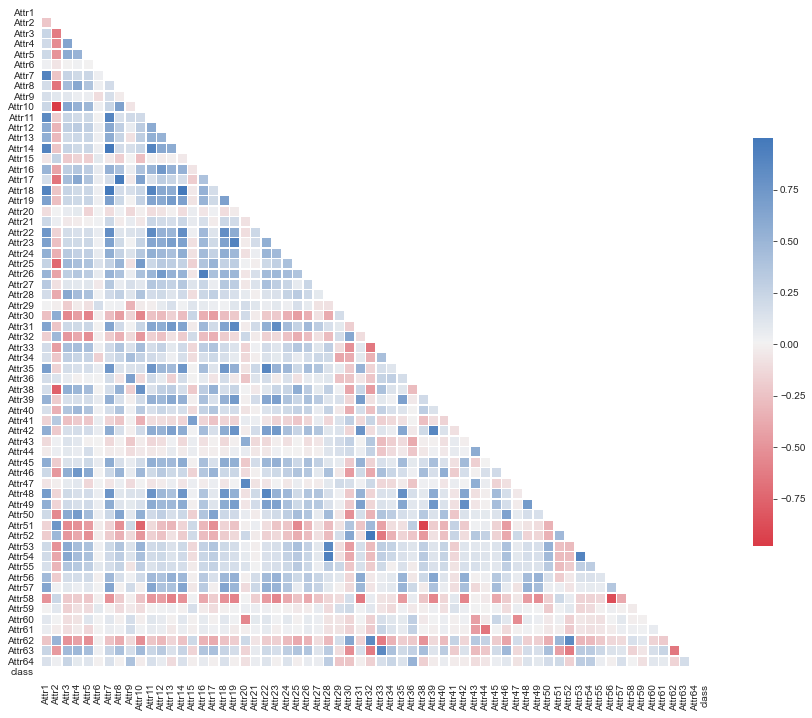

In [239]:
#Check Correlation matrix of median + outlier treated imputed data
corr_2 = df_treated_IQR_0.corr()
mask = np.triu(np.ones_like(corr_2, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_2, mask=mask,
            cmap=cmap,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax,
            xticklabels = df_treated_IQR_0.columns.tolist(),
            yticklabels = df_treated_IQR_0.columns.tolist())

Create the correlation groups and finalize the variables according to the groups

In [249]:
def correlation_group(correlation, percentile):
    correlation_pairs = correlation.unstack()
    high_correlation = correlation_pairs[(correlation_pairs>=percentile)|(correlation_pairs<= -1*percentile)]
    print(high_correlation)

In [250]:
correlation_group(corr_2 , 0.85)

Attr1   Attr1     1.000000
        Attr7     0.858639
        Attr14    0.858555
        Attr18    0.858583
Attr2   Attr2     1.000000
        Attr10   -0.979433
Attr3   Attr3     1.000000
Attr4   Attr4     1.000000
Attr5   Attr5     1.000000
Attr6   Attr6     1.000000
Attr7   Attr1     0.858639
        Attr7     1.000000
        Attr14    0.999927
        Attr18    0.999955
Attr8   Attr8     1.000000
        Attr17    0.938780
Attr9   Attr9     1.000000
Attr10  Attr2    -0.979433
        Attr10    1.000000
Attr11  Attr11    1.000000
Attr12  Attr12    1.000000
Attr13  Attr13    1.000000
Attr14  Attr1     0.858555
        Attr7     0.999927
        Attr14    1.000000
        Attr18    0.999997
Attr15  Attr15    1.000000
Attr16  Attr16    1.000000
        Attr26    0.886241
Attr17  Attr8     0.938780
        Attr17    1.000000
Attr18  Attr1     0.858583
        Attr7     0.999955
        Attr14    0.999997
        Attr18    1.000000
Attr19  Attr19    1.000000
        Attr23    0.863268
 

Columns with attributes 1,7,11,14,22,35,48 show positive correlation(>0.85)
Columns with attributes 3,6,10,25,38,51    show negative correlation(<-0.85)<br>
<b>Attributes positive correlation: </b><br>
1. Attr1 -net profit / total assets
2. Attr7 -EBIT(Earnings before interest and taxes) / total assets
3. Attr11-(gross profit + extraordinary items + financial expenses) / total assets
4. Attr14-(gross profit + interest) / total assets
5. Attr22- profit on operating activities / total assets
6. Attr35-profit on sales / total assets
7. Attr48-EBITDA (profit on operating activities - depreciation) / total assets <br>
<b>Attributes negative correlation:</b><br>
1. Attr3 -working capital / total assets
2. Attr6 -retained earnings / total assets
3. Attr10-equity / total assets
4. Attr25-(equity - share capital) / total assets
5. Attr38-constant capital / total assets
6. Attr51-short-term liabilities / total assets<br>
<b>We take the above attributes in a new dataframe</b>


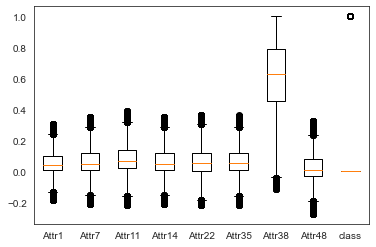

In [66]:
# Create new data frame with variables having high positive correlation
df_positive_relation = df_treated_IQR_0[["Attr1","Attr7","Attr11","Attr14","Attr22","Attr35","Attr38", "Attr48", "class"]]
#df_positive_relation.describe().round(3)
plt.boxplot(df_positive_relation, labels = df_positive_relation.columns )
plt.show()
#sns.pairplot(df_positive_relation, hue= "class")

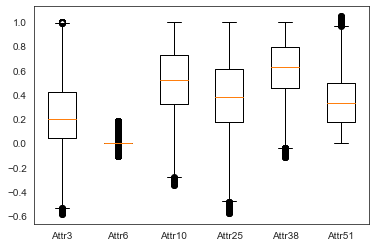

In [40]:
# Create new data frame with variables having high negative correlation
df_negative_relation = df_treated_IQR_0[['Attr3','Attr6','Attr10','Attr25','Attr38','Attr51']]
#df_negative_relation.describe().round(3)
plt.boxplot(df_negative_relation, labels = df_negative_relation.columns )
plt.show()

### Concatinating the dataframes

<b> Concatination of df_median_imputed_0 and df_median_imputed_1 </b>

In [196]:
df_median_imputed = pd.concat([df_median_imputed_0, df_median_imputed_1])
df_median_imputed.describe()

Attr1         Attr2         Attr3         Attr4         Attr5  \
count  10503.000000  10503.000000  10503.000000  10503.000000  1.050300e+04   
mean       0.052844      0.619911      0.095490      9.966167 -1.344447e+03   
std        0.647797      6.427041      6.420056    523.243080  1.184394e+05   
min      -17.692000      0.000000   -479.730000      0.002080 -1.190300e+07   
25%        0.000686      0.253955      0.017461      1.040900 -5.196150e+01   
50%        0.043034      0.464140      0.198560      1.607500  1.713300e+00   
75%        0.123805      0.689330      0.419545      2.952450  5.588350e+01   
max       52.652000    480.730000     17.708000  53433.000000  6.854400e+05   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean      -0.121159      0.065624     19.116068      1.819070      0.366093   
std        6.970625      0.651152    717.278474      7.580584      6.428603   
min     -508.120000    -17.692000     -2.081800     -1.215700   -479.730000   
25%        0.000000      0.002118      0.431935      1.011350      0.297340   
50%        0.000000      0.050945      1.112800      1.199000      0.515500   
75%        0.072584      0.142275      2.850750      2.059000      0.725635   
max       45.533000     52.652000  53432.000000    740.440000     11.837000   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10503.000000  10503.000000  10503.000000  10503.000000  1.050300e+04   
mean       0.086764      2.407406      0.375292      0.065634  3.002654e+03   
std        0.655407    111.364122     49.573752      0.651151  1.091565e+05   
min      -17.692000  -1543.800000   -631.710000    -17.692000 -2.321800e+06   
25%        0.009809      0.006372      0.020868      0.002131  1.867450e+02   
50%        0.068104      0.156130      0.066725      0.050953  8.044100e+02   
75%        0.161090      0.567870      0.133015      0.142275  2.186150e+03   
max       52.652000   8259.400000   4972.000000     52.652000  1.023600e+07   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       2.726329     20.487054      0.070739     -0.169947     68.310497   
std      110.160013    721.331800      0.835328     11.187235   1081.481194   
min     -204.300000     -0.043411    -17.692000   -771.650000     -0.001439   
25%        0.060454      1.450350      0.002131      0.001742     14.400500   
50%        0.235440      2.154500      0.050953      0.032454     34.332000   
75%        0.642430      3.922350      0.142285      0.087256     63.532500   
max     8259.400000  53433.000000     53.689000    123.940000  91600.000000   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       4.385225      0.075676     -0.175632      0.210998      0.196153   
std      293.911052      0.581734     11.126433      2.071102      6.742161   
min       -1.107500    -17.692000   -771.650000    -60.742000   -500.750000   
25%        0.813550      0.000000      0.000639      0.017663      0.135695   
50%        0.955370      0.054633      0.027351      0.165840      0.377690   
75%        1.088700      0.145890      0.075819      0.367400      0.614100   
max    29907.000000     47.597000    123.940000    179.920000      8.834500   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10503.000000  1.050300e+04  10503.000000  10503.000000  10503.000000   
mean       2.577577  1.105281e+03      5.970487      3.921179      0.458367   
std      108.751468  3.349082e+04     93.683591      0.840528     71.607994   
min     -204.300000 -1.901300e+05   -690.400000     -0.358530  -6351.700000   
25%        0.055273  1.449050e-02      0.035968      3.3932

<b> Concatination of df_treated_IQR_0 and df_treated_IQR_1 </b>

In [197]:
df_treated_IQR = pd.concat([df_treated_IQR_0, df_treated_IQR_1])
df_treated_IQR.describe()

Attr1         Attr2         Attr3         Attr4         Attr5  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.054746      0.471460      0.225481      1.801945      2.030702   
std        0.089216      0.270431      0.287314      1.149583     69.954355   
min       -0.261070      0.000000     -0.691170      0.002080   -234.890000   
25%        0.006776      0.253955      0.037879      1.040900    -31.855500   
50%        0.045404      0.455845      0.205955      1.591400      3.284400   
75%        0.101290      0.664360      0.417900      2.196750     34.773000   
max        0.314790      1.442200      1.000000      5.922700    219.860000   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.009994      0.064588      1.386555      1.416827      0.512367   
std        0.049703      0.102730      1.421489      0.712978      0.268754   
min       -0.247110     -0.273970     -2.081800     -0.000084     -0.441890   
25%        0.000000      0.008790      0.431935      1.011450      0.320355   
50%        0.000000      0.054174      1.094300      1.194300      0.525320   
75%        0.000000      0.120100      1.810050      1.761550      0.725115   
max        0.207090      0.358790      6.647500      3.920900      1.000000   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.079678      0.203366      0.074685      0.064604    988.538586   
std        0.108441      0.371883      0.078165      0.102725   1439.244612   
min       -0.275890     -0.863780     -0.177480     -0.273970  -9254.600000   
25%        0.018480      0.016271      0.028521      0.008808    320.550000   
50%        0.071158      0.167200      0.069723      0.054229    800.905000   
75%        0.139125      0.334460      0.114460      0.120100   1472.150000   
max        0.391910      1.465400      0.308040      0.358790  12004.000000   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.283812      2.428049      0.064602      0.040901     38.334180   
std        0.374602      1.445330      0.102725      0.061570     30.746746   
min       -0.817440     -0.043411     -0.273970     -0.221360     -0.001439   
25%        0.066964      1.450350      0.008808      0.008049     14.400500   
50%        0.244870      2.134700      0.054229      0.034398     34.289000   
75%        0.410065      2.869500      0.120100      0.071178     54.711000   
max        1.567900      7.775900      0.358790      0.220550    172.140000   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.944658      0.068345      0.035023      0.184993      0.384206   
std        0.200000      0.103127      0.054128      0.246810      0.304299   
min        0.393670     -0.266750     -0.221360     -0.499460     -0.582870   
25%        0.830755      0.000000      0.006664      0.032363      0.176300   
50%        0.955370      0.056921      0.028951      0.168500      0.391945   
75%        1.049700      0.122935      0.060650      0.318490      0.613680   
max        1.508700      0.371730      0.192140      0.904430      1.000000   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.257103      1.302156      0.560518      3.922071      0.230603   
std        0.340171      2.242314      0.852698      0.779262      0.231570   
min       -0.754360     -6.581000     -2.182200      1.740300     -0.485610   
25%        0.062188      0.274690      0.065968      3.4102

<b> Concatination of df_treated_anomaly_0 and df_treated_anomaly_1 </b>

In [198]:
df_treated_anomaly = pd.concat([df_treated_anomaly_0, df_treated_anomaly_1])
df_treated_anomaly.describe()

Attr1        Attr2        Attr3        Attr4         Attr5  \
count  9452.000000  9452.000000  9452.000000  9452.000000  9.452000e+03   
mean      0.058116     0.485376     0.207121     2.515875 -1.541880e+03   
std       0.131164     0.284535     0.287555     2.819640  1.246246e+05   
min      -0.961250     0.000000    -2.095500     0.037783 -1.190300e+07   
25%       0.003459     0.266630     0.028725     1.068700 -4.854525e+01   
50%       0.044626     0.462950     0.197595     1.593600  1.190550e+00   
75%       0.118740     0.668975     0.400750     2.780275  5.117950e+01   
max       0.780890     5.368500     1.000000    35.250000  6.837700e+05   

             Attr6        Attr7        Attr8        Attr9       Attr10  \
count  9452.000000  9452.000000  9452.000000  9452.000000  9452.000000   
mean      0.034569     0.070074     2.562707     1.658760     0.497486   
std       0.801343     0.141636     9.155243     1.185988     0.284217   
min     -70.966000    -0.961250    -0.813730     0.000000    -4.368500   
25%       0.000000     0.005704     0.471425     1.017900     0.314065   
50%       0.000000     0.053011     1.114800     1.195250     0.516050   
75%       0.088603     0.137263     2.674375     2.000500     0.711405   
max      17.113000     0.780890   757.070000    22.786000     1.000000   

            Attr11       Attr12       Attr13       Attr14        Attr15  \
count  9452.000000  9452.000000  9452.000000  9452.000000  9.452000e+03   
mean      0.087784     0.392274     0.080268     0.070074  3.283333e+03   
std       0.144485     0.936241     0.117229     0.141636  1.148502e+05   
min      -0.929950    -6.236200    -1.448600    -0.961250 -2.321800e+06   
25%       0.015235     0.015104     0.024352     0.005704  2.957700e+02   
50%       0.069969     0.160960     0.067001     0.053011  9.334700e+02   
75%       0.155492     0.523360     0.127700     0.137263  2.365925e+03   
max       1.016900    12.682000     0.997980     0.780890  1.023600e+07   

            Attr16       Attr17       Attr18       Attr19       Attr20  \
count  9452.000000  9452.000000  9452.000000  9452.000000  9452.000000   
mean      0.505136     3.634228     0.070074     0.038314    48.482311   
std       0.927377     9.186288     0.141636     0.102769    51.146254   
min      -4.811100     0.186270    -0.961250    -1.450800     0.000000   
25%       0.074343     1.494775     0.005704     0.003748    15.909750   
50%       0.238045     2.159750     0.053011     0.033195    35.336000   
75%       0.600955     3.742975     0.137263     0.083966    63.598750   
max      15.655000   758.070000     0.780890     0.764490   902.890000   

            Attr21       Attr22       Attr23       Attr24       Attr25  \
count  9452.000000  9452.000000  9452.000000  9452.000000  9452.000000   
mean      1.451659     0.079653     0.031008     0.235665     0.366654   
std      35.939467     0.137111     0.097087     1.878844     0.357095   
min       0.000000    -0.946080    -1.482600    -2.235800    -5.796300   
25%       0.823368     0.000000     0.002172     0.030883     0.165860   
50%       0.955370     0.058260     0.028033     0.168500     0.390520   
75%       1.089600     0.142978     0.072118     0.360320     0.612085   
max    3453.200000     1.014600     0.849890   179.920000     1.000000   

            Attr26        Attr27       Attr28       Attr29       Attr30  \
count  9452.000000  9.452000e+03  9452.000000  9452.000000  9452.000000   
mean      0.455373  7.998690e+02     2.282872     3.994727     0.310606   
std       0.868699  3.060115e+04    10.799310     0.785702     0.597599   
min     -10.641000 -1.901300e+05   -90.979000    -0.349690    -3.560300   
25%       0.067849  1.255650e-01     0.053643     3.473050     0.083268   
50%       0.217195  1.071050e+00     0.473405     3.988300     0.217650   
75%       0.540297  4.064175e+00     1.435600     4.485025     0.405353   
max      15.655000  2.723000e+06   513.740000     9.619900  

<b> Concatination of df_treated_capping_0 and df_treated_capping_1 </b>

In [199]:
df_treated_capping = pd.concat([df_treated_capping_0, df_treated_capping_1])
df_treated_capping.describe()

Attr1         Attr2         Attr3         Attr4         Attr5  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.054836      0.495590      0.206927      2.246172      3.083910   
std        0.124035      0.305665      0.315604      1.691635    108.764010   
min       -0.265142      0.000000     -0.692338      0.002080   -237.482175   
25%        0.000686      0.253955      0.017461      1.040900    -51.961500   
50%        0.043034      0.464140      0.198560      1.607500      1.713300   
75%        0.123805      0.689330      0.419545      2.952450     55.883500   
max        0.314962      1.464068      1.029844      5.949113    220.045500   

              Attr6         Attr7         Attr8         Attr9        Attr10  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.025464      0.065676      1.966763      1.585158      0.488566   
std        0.103196      0.138032      2.130949      0.904351      0.304761   
min       -0.247522     -0.276917     -2.081800     -0.551863     -0.441923   
25%        0.000000      0.002118      0.431935      1.011350      0.297340   
50%        0.000000      0.050945      1.112800      1.199000      0.515500   
75%        0.072584      0.142275      2.774500      2.059000      0.725635   
max        0.207399      0.358884      6.647525      3.940667      1.367114   

             Attr11        Attr12        Attr13        Attr14        Attr15  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.082849      0.303448      0.076973      0.065687   1171.988787   
std        0.143289      0.576819      0.107164      0.138026   2303.655004   
min       -0.277992     -0.865834     -0.180534     -0.276917  -9555.250000   
25%        0.009809      0.006372      0.020868      0.002131    186.745000   
50%        0.068104      0.156130      0.066725      0.050953    804.410000   
75%        0.161090      0.567870      0.133015      0.142275   2186.150000   
max        0.391962      1.469004      0.308061      0.358872  12117.150000   

             Attr16        Attr17        Attr18        Attr19        Attr20  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.406811      3.022580      0.065723      0.038695     44.700999   
std        0.564958      2.171162      0.138128      0.089005     38.941891   
min       -0.830647     -0.043411     -0.276917     -0.222312     -0.001439   
25%        0.060454      1.450350      0.002131      0.001742     14.400500   
50%        0.235440      2.154500      0.050953      0.032454     34.332000   
75%        0.633520      3.847250      0.142285      0.087256     63.532500   
max        1.570068      7.776537      0.359316      0.220749    175.299250   

             Attr21        Attr22        Attr23        Attr24        Attr25  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.960843      0.072974      0.032047      0.197105      0.349001   
std        0.247942      0.135499      0.079836      0.314093      0.356322   
min        0.393562     -0.270436     -0.221955     -0.501190     -0.660439   
25%        0.813550      0.000000      0.000639      0.017663      0.135695   
50%        0.955370      0.054633      0.027351      0.165840      0.377690   
75%        1.088700      0.145890      0.075819      0.367400      0.614100   
max        1.508822      0.371769      0.192492      0.905478      1.335880   

             Attr26        Attr27        Attr28        Attr29        Attr30  \
count  10503.000000  10503.000000  10503.000000  10503.000000  10503.000000   
mean       0.366811      2.409113      0.927737      3.921690      0.271905   
std        0.517493      4.655792      1.414554      0.823715      0.313613   
min       -0.756730     -6.585156     -2.188093      1.723350     -0.488602   
25%        0.055273      0.014490      0.035968      3.3932

In [202]:
x_MI_train, x_MI_test, y_MI_train, y_MI_test = preprocessing_TTS(df_median_imputed)

In [208]:
x_TIQR_train, x_TIQR_test, y_TIQR_train, y_TIQR_test = preprocessing_TTS(df_treated_IQR)

In [209]:
x_TA_train, x_TA_test, y_TA_train, y_TA_test = preprocessing_TTS(df_treated_anomaly)

In [210]:
x_TC_train, x_TC_test, y_TC_train, y_TC_test = preprocessing_TTS(df_treated_capping)

In [212]:
# Feature Selection for capped data 
train_result_capping = RF_FeatureSelector(x_TC_train, x_TC_test, y_TC_train, y_TC_test)
capping_results = pd.DataFrame(train_result_capping, columns=['weight','predictors','recall','predictor_names'])
capping_results

weight  predictors  recall  \
0        1          12    0.97   
1        2          13    0.97   
2        3          13    0.97   
3        4          13    0.97   
4        5          13    0.97   
5        6          14    0.97   
6        7          14    0.97   
7        8          14    0.97   
8        9          13    0.97   
9       10          13    0.97   
10      11          12    0.97   
11      12          13    0.97   
12      13          13    0.97   
13      14          11    0.97   
14      15          11    0.97   
15      16          11    0.97   
16      17          13    0.97   
17      18          14    0.98   
18      19          13    0.96   

                                      predictor_names  
0   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,...  
1   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,...  
2   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,...  
3   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,...  
4   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr27,...  
5   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
6   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
7   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
8   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
9   [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
10  [Attr6, Attr9, Attr15, Attr20, Attr23, Attr26,...  
11  [Attr6, Attr15, Attr16, Attr20, Attr23, Attr26...  
12  [Attr6, Attr15, Attr16, Attr20, Attr23, Attr26...  
13  [Attr6, Attr15, Attr16, Attr23, Attr26, Attr27...  
14  [Attr6, Attr15, Attr16, Attr23, Attr26, Attr27...  
15  [Attr6, Attr15, Attr16, Attr23, Attr26, Attr27...  
16  [Attr6, Attr8, Attr15, Attr16, Attr23, Attr26,...  
17  [Attr6, Attr8, Attr15, Attr16, Attr23, Attr26,...  
18  [Attr6, Attr8, Attr15, Attr16, Attr23, Attr26,...

In [214]:
print("The proposed predictors to be used, based on RFC, are: ",capping_results.iloc[17,3].tolist())
print("This is done with a weight of: ",capping_results.iloc[17,0])
print("Recall is ",capping_results.iloc[17,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr6', 'Attr8', 'Attr15', 'Attr16', 'Attr23', 'Attr26', 'Attr27', 'Attr34', 'Attr41', 'Attr55', 'Attr59', 'Attr60', 'Attr61', 'Attr64']
This is done with a weight of:  18
Recall is  0.98


<b> Confusion Matrix for capped dataframe</b>

In [218]:
forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 14, max_depth = 40, class_weight={0:1,1:18}, random_state = 42)
forest_cimoc.fit(x_TC_train, y_TC_train)

y_pred = forest_cimoc.predict(x_TC_test)
y_test = y_TC_test

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))


Confusion matrix of Random Forest optimized for Recall on the test data:
     pred_neg  pred_pos
neg      2002         0
pos         6        93


In [219]:
#Feature selection for anomaly removed data
train_result_anomaly = RF_FeatureSelector(x_TA_train, x_TA_test, y_TA_train, y_TA_test)
anomaly_results = pd.DataFrame(train_result_anomaly, columns=['weight','predictors','recall','predictor_names'])
anomaly_results

weight  predictors  recall  \
0        1          17    0.65   
1        2          17    0.65   
2        3          16    0.66   
3        4          17    0.66   
4        5          16    0.66   
5        6          14    0.66   
6        7          13    0.66   
7        8          13    0.66   
8        9          13    0.65   
9       10          13    0.66   
10      11          13    0.66   
11      12          13    0.67   
12      13          12    0.66   
13      14          13    0.65   
14      15          13    0.66   
15      16          14    0.66   
16      17          14    0.66   
17      18          13    0.65   
18      19          13    0.66   

                                      predictor_names  
0   [Attr5, Attr15, Attr21, Attr24, Attr25, Attr27...  
1   [Attr5, Attr15, Attr16, Attr21, Attr24, Attr25...  
2   [Attr5, Attr16, Attr21, Attr24, Attr25, Attr26...  
3   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
4   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
5   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
6   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
7   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
8   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
9   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
10  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
11  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
12  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
13  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
14  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
15  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
16  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
17  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
18  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...

In [221]:
print("The proposed predictors to be used, based on RFC, are: ",anomaly_results.iloc[11,3].tolist())
print("This is done with a weight of: ",anomaly_results.iloc[11,0])
print("Recall is ",anomaly_results.iloc[11,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr5', 'Attr13', 'Attr16', 'Attr21', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr34', 'Attr38', 'Attr41', 'Attr46', 'Attr58']
This is done with a weight of:  12
Recall is  0.67


In [223]:
forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 13, max_depth = 40, class_weight={0:1,1:12}, random_state = 42)
forest_cimoc.fit(x_TA_train, y_TA_train)

y_pred = forest_cimoc.predict(x_TA_test)
y_test = y_TA_test

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))


Confusion matrix of Random Forest optimized for Recall on the test data:
     pred_neg  pred_pos
neg      1801         1
pos        66        23


In [224]:
# Feature Selection for IQR treated dataframe
train_result_IQR = RF_FeatureSelector(x_TIQR_train, x_TIQR_test, y_TIQR_train, y_TIQR_test)
IQR_results = pd.DataFrame(train_result_IQR, columns=['weight','predictors','recall','predictor_names'])
IQR_results

weight  predictors  recall  \
0        1          15    0.93   
1        2          10    0.92   
2        3          10    0.88   
3        4           9    0.87   
4        5          10    0.87   
5        6           9    0.87   
6        7           9    0.86   
7        8           9    0.87   
8        9           9    0.84   
9       10           9    0.83   
10      11          10    0.82   
11      12          10    0.83   
12      13          10    0.81   
13      14           9    0.81   
14      15          10    0.80   
15      16           9    0.81   
16      17           9    0.82   
17      18           9    0.81   
18      19           9    0.80   

                                      predictor_names  
0   [Attr6, Attr15, Attr20, Attr23, Attr27, Attr30...  
1   [Attr6, Attr15, Attr20, Attr23, Attr27, Attr39...  
2   [Attr6, Attr15, Attr20, Attr24, Attr26, Attr27...  
3   [Attr15, Attr20, Attr24, Attr26, Attr27, Attr4...  
4   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
5   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
6   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
7   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
8   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
9   [Attr15, Attr16, Attr24, Attr26, Attr27, Attr4...  
10  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
11  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
12  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
13  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
14  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
15  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
16  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
17  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...  
18  [Attr15, Attr16, Attr24, Attr26, Attr27, Attr3...

In [225]:
print("The proposed predictors to be used, based on RFC, are: ",IQR_results.iloc[0,3].tolist())
print("This is done with a weight of: ",IQR_results.iloc[0,0])
print("Recall is ",IQR_results.iloc[0,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr6', 'Attr15', 'Attr20', 'Attr23', 'Attr27', 'Attr30', 'Attr32', 'Attr35', 'Attr39', 'Attr41', 'Attr45', 'Attr51', 'Attr57', 'Attr59', 'Attr61']
This is done with a weight of:  1
Recall is  0.93


In [226]:
forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 15, max_depth = 40, class_weight={0:1,1:1}, random_state = 42)
forest_cimoc.fit(x_TIQR_train, y_TIQR_train)

y_pred = forest_cimoc.predict(x_TIQR_test)
y_test = y_TIQR_test

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))


Confusion matrix of Random Forest optimized for Recall on the test data:
     pred_neg  pred_pos
neg      2002         0
pos        18        81


In [227]:
# Feature Selection for Median Imputed dataframe
train_result_MI = RF_FeatureSelector(x_MI_train, x_MI_test, y_MI_train, y_MI_test)
MI_results = pd.DataFrame(train_result_MI, columns=['weight','predictors','recall','predictor_names'])
MI_results

weight  predictors  recall  \
0        1          17    0.64   
1        2          17    0.65   
2        3          15    0.66   
3        4          12    0.65   
4        5          12    0.65   
5        6          10    0.64   
6        7          10    0.65   
7        8          11    0.66   
8        9          12    0.66   
9       10          10    0.66   
10      11          11    0.65   
11      12          11    0.65   
12      13          11    0.65   
13      14          11    0.65   
14      15          12    0.65   
15      16          12    0.66   
16      17          11    0.65   
17      18          13    0.65   
18      19          15    0.65   

                                      predictor_names  
0   [Attr5, Attr15, Attr20, Attr21, Attr24, Attr26...  
1   [Attr5, Attr15, Attr20, Attr21, Attr24, Attr26...  
2   [Attr5, Attr15, Attr20, Attr21, Attr24, Attr26...  
3   [Attr5, Attr15, Attr20, Attr21, Attr24, Attr26...  
4   [Attr5, Attr15, Attr21, Attr24, Attr26, Attr27...  
5   [Attr5, Attr16, Attr21, Attr24, Attr26, Attr27...  
6   [Attr5, Attr16, Attr21, Attr24, Attr26, Attr27...  
7   [Attr5, Attr16, Attr21, Attr24, Attr26, Attr27...  
8   [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
9   [Attr5, Attr16, Attr21, Attr24, Attr26, Attr27...  
10  [Attr5, Attr16, Attr21, Attr24, Attr26, Attr27...  
11  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
12  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
13  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
14  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
15  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
16  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr26...  
17  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...  
18  [Attr5, Attr13, Attr16, Attr21, Attr24, Attr25...

In [228]:
print("The proposed predictors to be used, based on RFC, are: ",MI_results.iloc[7,3].tolist())
print("This is done with a weight of: ",MI_results.iloc[7,0])
print("Recall is ",MI_results.iloc[7,2] )

The proposed predictors to be used, based on RFC, are:  ['Attr5', 'Attr16', 'Attr21', 'Attr24', 'Attr26', 'Attr27', 'Attr29', 'Attr34', 'Attr45', 'Attr46', 'Attr58']
This is done with a weight of:  8
Recall is  0.66


In [230]:
forest_cimoc = RandomForestClassifier(n_estimators = 100, max_features = 11, max_depth = 40, class_weight={0:1,1:8}, random_state = 42)
forest_cimoc.fit(x_MI_train, y_MI_train)

y_pred = forest_cimoc.predict(x_MI_test)
y_test = y_MI_test

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))


Confusion matrix of Random Forest optimized for Recall on the test data:
     pred_neg  pred_pos
neg      1999         3
pos        84        15


## Hyper Parameter Tuning

In [233]:
# Building the dictionaries
param_grid = { 
                'n_estimators' : [50,100,200,300,400,500],
                'max_features' : ['auto', 'sqrt', 'log2'],    
                'max_depth'    : [10,20,30,40,50],
                'criterion'    : ['gini', 'entropy']
             }

# We do the Grid Search
rfc         = RandomForestClassifier(class_weight={0:1,1:18},random_state=42)
skf         = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(rfc, param_grid, scoring="recall", refit="recall", cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(x_TC_train, y_TC_train)
y_pred      = grid_search.predict(x_TC_test)

print('Best params for Recall')
print(grid_search.best_params_)

recall_ = recall_score(y_TC_test, y_pred, average='macro')
print("Recall: {:.2f}".format(recall_.round(decimals=2)))

# Confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for Recall on the test data:')
print(pd.DataFrame(confusion_matrix(y_TC_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Best params for Recall
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
Recall: 0.99

Confusion matrix of Random Forest optimized for Recall on the test data:
     pred_neg  pred_pos
neg      2002         0
pos         2        97


C:\Users\Swapnali\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


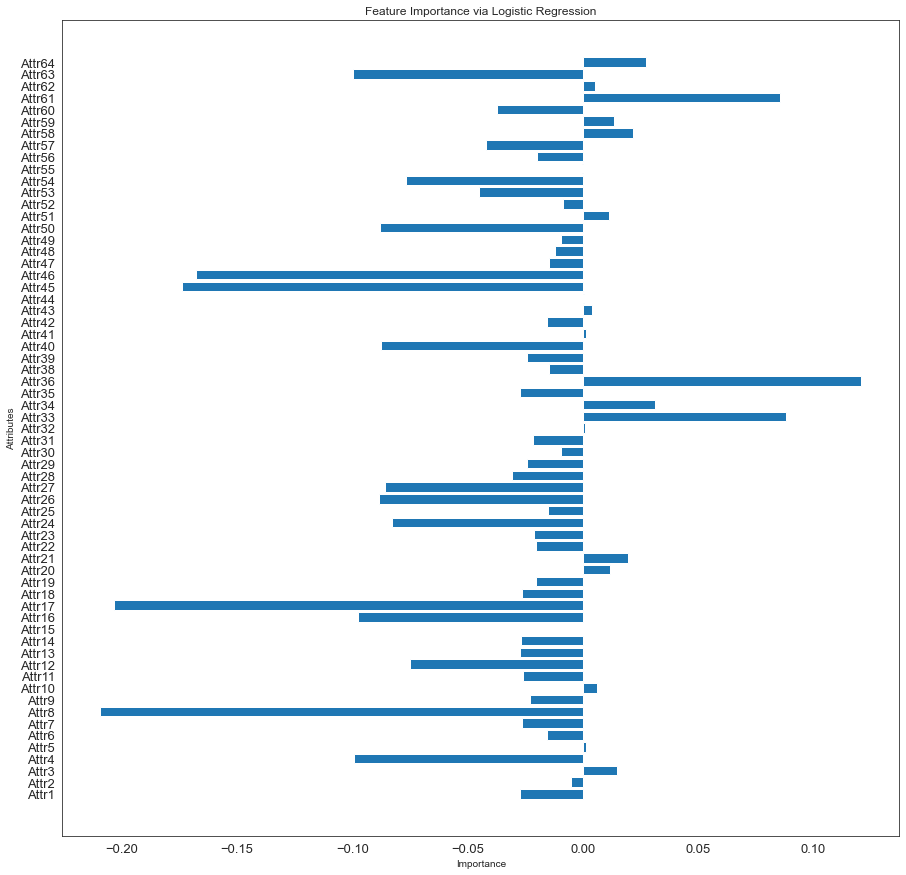

In [242]:
# Logistic regression model for feature selection
lr_model = LogisticRegression(random_state=42, solver='saga',class_weight={0:1,1:20}, max_iter=20000)
lr_model.fit(x_TIQR_train, y_TIQR_train)
lr_feature_importance = lr_model.coef_[0]
lr_features = np.asarray(x_TIQR_train.columns)
plt.figure(figsize=(15,15))
plt.barh(lr_features, lr_feature_importance)
plt.title('Feature Importance via Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Attributes')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

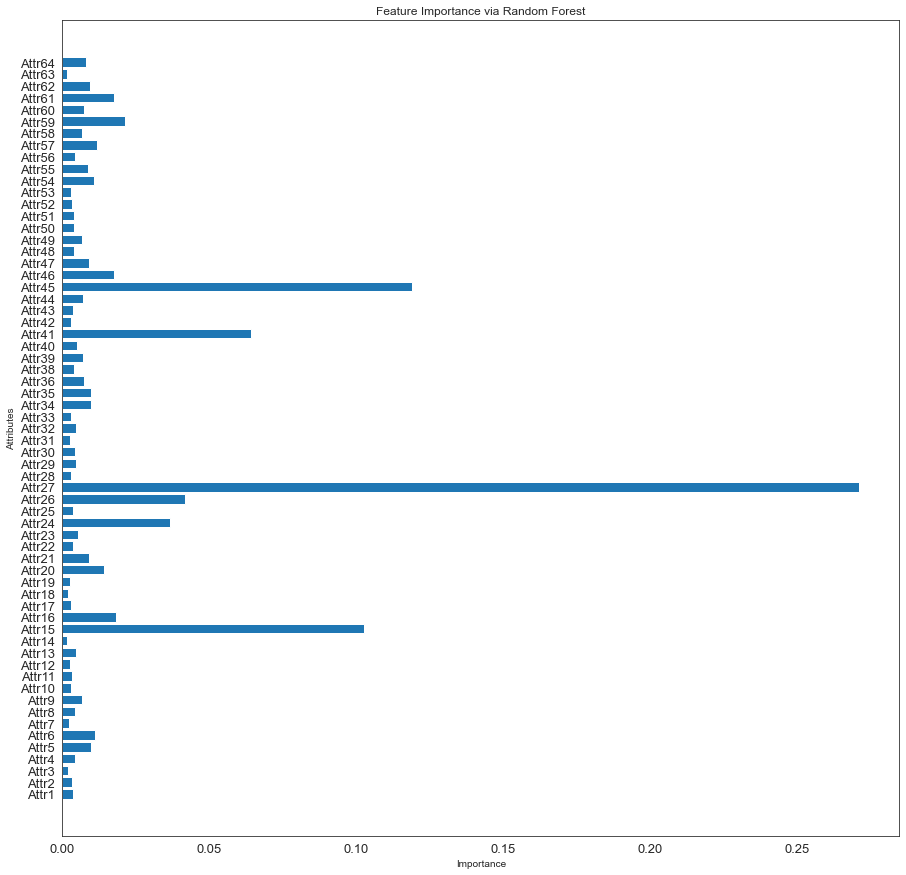

In [243]:
# Random Forest Classifier model for feature selection
forest = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40,class_weight={0:1,1:5}, random_state=42)
forest.fit(x_TIQR_train, y_TIQR_train)
forest_features = np.asarray(x_TIQR_train.columns)
forest_importance = forest.feature_importances_
plt.figure(figsize=(15,15))
plt.barh(forest_features, forest_importance)
plt.title('Feature Importance via Random Forest')
plt.xlabel('Importance')
plt.ylabel('Attributes')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

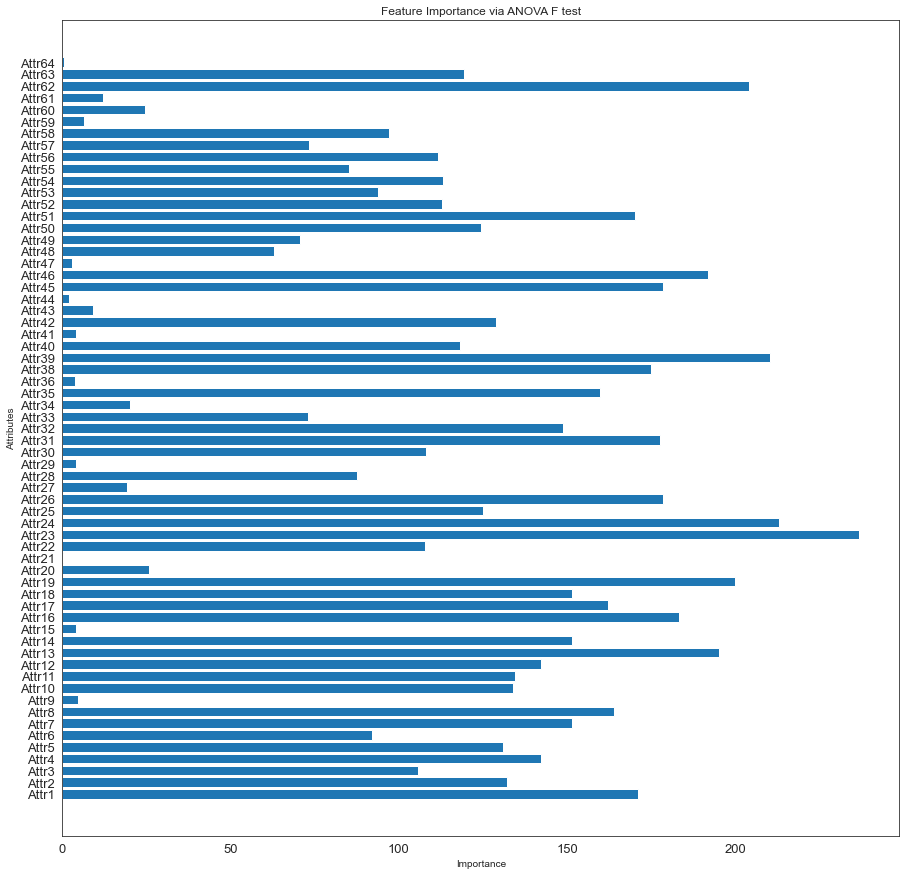

In [244]:
# ANOVA F test model for feature selection
anova = SelectKBest(score_func=f_classif, k='all')
anova.fit(x_TIQR_train, y_TIQR_train)
anova_features = np.asarray(x_TIQR_train.columns)
anova_importance = anova.scores_
plt.figure(figsize=(15,15))
plt.barh(anova_features, anova_importance)
plt.title('Feature Importance via ANOVA F test')
plt.xlabel('Importance')
plt.ylabel('Attributes')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()